In [3]:
import cv2
from matplotlib import pyplot as plt
import pickle
with open(f"../../datasets/without_bg_revision/annotations/train/revision_data.pkl", "rb") as st_json:
    meta = pickle.load(st_json)

In [4]:

def get_transform(center, scale, res, rot=0):
    """Generate transformation matrix."""
    h = res[0] * scale
    # h = 200 * scale
    t = np.zeros((3, 3))
    t[0, 0] = float(res[1]) / h
    t[1, 1] = float(res[0]) / h
    t[0, 2] = res[1] * (-float(center[0]) / h + .5)
    t[1, 2] = res[0] * (-float(center[1]) / h + .5)
    t[2, 2] = 1
    if not rot == 0:
        rot = -rot # To match direction of rotation from cropping
        rot_mat = np.zeros((3,3))
        rot_rad = rot * np.pi / 180
        sn,cs = np.sin(rot_rad), np.cos(rot_rad)
        rot_mat[0,:2] = [cs, -sn]
        rot_mat[1,:2] = [sn, cs]
        rot_mat[2,2] = 1
        # Need to rotate around center
        t_mat = np.eye(3)
        t_mat[0,2] = -res[1]/2
        t_mat[1,2] = -res[0]/2
        t_inv = t_mat.copy()
        t_inv[:2,2] *= -1
        t = np.dot(t_inv,np.dot(rot_mat,np.dot(t_mat,t)))
    return t


def transform(pt, center, scale, res, invert=0, rot=0):
    """Transform pixel location to different reference."""
    t = get_transform(center, scale, res, rot=rot)
    if invert:
        # t = np.linalg.inv(t)
        t_torch = torch.from_numpy(t)
        t_torch = torch.inverse(t_torch)
        t = t_torch.numpy()
    new_pt = np.array([pt[0]-1, pt[1]-1, 1.]).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2].astype(int)+1


def crop(img, center, scale, res, rot=0):
    """Crop image according to the supplied bounding box."""
    # Upper left point
    ul = np.array(transform([1, 1], center, scale, res, invert=1))-1
    # Bottom right point
    br = np.array(transform([res[0]+1, 
                             res[1]+1], center, scale, res, invert=1))-1
    # Padding so that when rotated proper amount of context is included
    pad = int(np.linalg.norm(br - ul) / 2 - float(br[1] - ul[1]) / 2)
    if not rot == 0:
        ul -= pad
        br += pad
    new_shape = [br[1] - ul[1], br[0] - ul[0]]
    if len(img.shape) > 2:
        new_shape += [img.shape[2]]
    new_img = np.zeros(new_shape)

    # Range to fill new array
    new_x = max(0, -ul[0]), min(br[0], len(img[0])) - ul[0]
    new_y = max(0, -ul[1]), min(br[1], len(img)) - ul[1]
    # Range to sample from original image
    old_x = max(0, ul[0]), min(len(img[0]), br[0])
    old_y = max(0, ul[1]), min(len(img), br[1])

    new_img[new_y[0]:new_y[1], new_x[0]:new_x[1]] = img[old_y[0]:old_y[1], 
                                                        old_x[0]:old_x[1]]
    if not rot == 0:
        # Remove padding
        # new_img = scipy.misc.imrotate(new_img, rot)
        new_img = myimrotate(new_img, rot)
        new_img = new_img[pad:-pad, pad:-pad]

    # new_img = scipy.misc.imresize(new_img, res)
    new_img = myimresize(new_img, [res[0], res[1]])
    return new_img


def myimrotate(img, angle, center=None, scale=1.0, border_value=0, auto_bound=False):
    if center is not None and auto_bound:
        raise ValueError('`auto_bound` conflicts with `center`')
    h, w = img.shape[:2]
    if center is None:
        center = ((w - 1) * 0.5, (h - 1) * 0.5)
    assert isinstance(center, tuple)

    matrix = cv2.getRotationMatrix2D(center, angle, scale)
    if auto_bound:
        cos = np.abs(matrix[0, 0])
        sin = np.abs(matrix[0, 1])
        new_w = h * sin + w * cos
        new_h = h * cos + w * sin
        matrix[0, 2] += (new_w - w) * 0.5
        matrix[1, 2] += (new_h - h) * 0.5
        w = int(np.round(new_w))
        h = int(np.round(new_h))
    rotated = cv2.warpAffine(img, matrix, (w, h), borderValue=border_value)
    return rotated

def myimresize(img, size, return_scale=False):

    h, w = img.shape[:2]
    resized_img = cv2.resize(
        img, (size[0],size[1]))
    if not return_scale:
        return resized_img
    else:
        w_scale = size[0] / w
        h_scale = size[1] / h
        return resized_img, w_scale, h_scale


In [6]:

def j2d_processing(kp, scale, r):
    """Process gt 2D keypoints and apply all augmentation transforms."""
    nparts = kp.shape[0]
    for i in range(nparts):
        kp[i, 0:2] = transform(kp[i, 0:2]+1, (512/2, 512/2), scale,
                                [512, 512], rot=r)
    return kp

def transform(pt, center, scale, res, invert=0, rot=0):
    """Transform pixel location to different reference."""
    t = get_transform(center, scale, res, rot=rot)
    if invert:
        # t = np.linalg.inv(t)
        t_torch = torch.from_numpy(t)
        t_torch = torch.inverse(t_torch)
        t = t_torch.numpy()
    new_pt = np.array([pt[0]-1, pt[1]-1, 1.]).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2].astype(int)+1

In [12]:
colors = np.array([[0.4, 0.4, 0.4],
                [0.4, 0.0, 0.0],
                [0.6, 0.0, 0.0],
                [0.8, 0.0, 0.0],
                [1.0, 0.0, 0.0],
                [0.4, 0.4, 0.0],
                [0.6, 0.6, 0.0],
                [0.8, 0.8, 0.0],
                [1.0, 1.0, 0.0],
                [0.0, 0.4, 0.2],
                [0.0, 0.6, 0.3],
                [0.0, 0.8, 0.4],
                [0.0, 1.0, 0.5],
                [0.0, 0.2, 0.4],
                [0.0, 0.3, 0.6],
                [0.0, 0.4, 0.8],
                [0.0, 0.5, 1.0],
                [0.4, 0.0, 0.4],
                [0.6, 0.0, 0.6],
                [0.7, 0.0, 0.8],
                [1.0, 0.0, 1.0]])

colors = colors[:, ::-1]

# define connections and colors of the bones
bones = [((0, 1), colors[1, :]),
        ((1, 2), colors[2, :]),
        ((2, 3), colors[3, :]),
        ((3, 4), colors[4, :]),

        ((0, 5), colors[5, :]),
        ((5, 6), colors[6, :]),
        ((6, 7), colors[7, :]),
        ((7, 8), colors[8, :]),

        ((0, 9), colors[9, :]),
        ((9, 10), colors[10, :]),
        ((10, 11), colors[11, :]),
        ((11, 12), colors[12, :]),

        ((0, 13), colors[13, :]),
        ((13, 14), colors[14, :]),
        ((14, 15), colors[15, :]),
        ((15, 16), colors[16, :]),

        ((0, 17), colors[17, :]),
        ((17, 18), colors[18, :]),
        ((18, 19), colors[19, :]),
        ((19, 20), colors[20, :])]
    

In [27]:
def visualize(image, joint_2d):
    parents = np.array([-1, 0, 1, 2, 3, 0, 5, 6, 7, 0, 9, 10, 11, 0, 13, 14, 15, 0, 17, 18, 19])
    for i in range(21):
        cv2.circle(image, (int(joint_2d[i][0]), int(joint_2d[i][1])), 2, colors[i] * 255,
                    thickness=2)
        if i != 0:
            cv2.line(image, (int(joint_2d[i][0]), int(joint_2d[i][1])),
                        (int(joint_2d[parents[i]][0]), int(joint_2d[parents[i]][1])),
                        colors[i] * 255, 2)
            
    return image

/home/jeongho/miniconda3/envs/dart/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


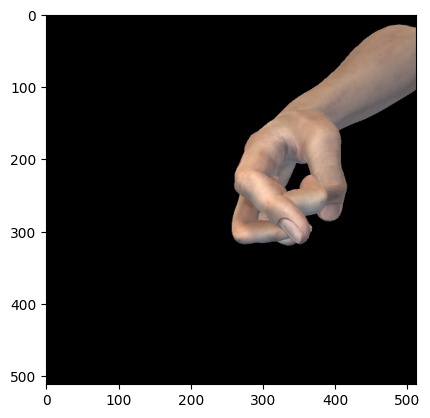

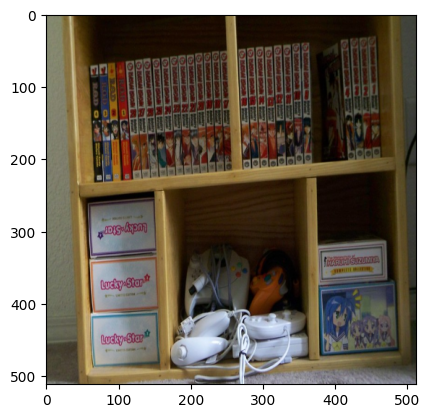

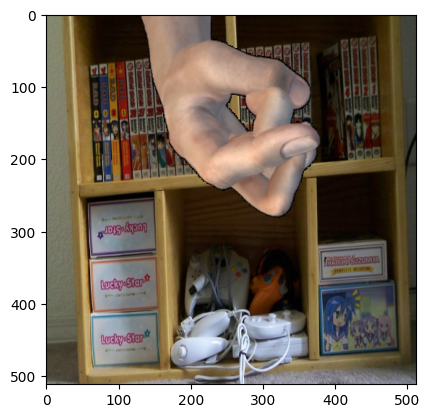

In [ ]:

import pickle5 as pickle
from PIL import Image
import json
import cv2
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

for idx in range(44,45):

    raw_res = 512
    bg_path = "../../datasets/without_bg_revision/background"
    bg_list = os.listdir(bg_path)
    img_path = os.path.join("../../datasets/without_bg_revision", f"images/train")
    name = '/'.join(meta[idx]['file_name'].split('/')[1:])
    image = cv2.imread(os.path.join(img_path, name))  # PIL image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)[:,:, (2, 1, 0)]
    
    
    
    joint_2d = np.array(meta[idx]['joint_2d'])
    joint_3d = meta[idx]['joint_3d']    
    scale = meta[idx]['scale']   
    rot = meta[idx]['rot']       

    cropped_img = crop(image, (raw_res/2, raw_res/2), scale, [raw_res, raw_res], rot=rot)
    # rot_img = crop(image, (raw_res/2, raw_res/2), scale, [raw_res, raw_res], rot=rot)
    bg_img = cv2.imread(os.path.join(bg_path, bg_list[idx%len(bg_list)]))
    bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB)
    bg_img = cv2.resize(bg_img, (512, 512))

    iaz = np.where((cropped_img[:, :, 0] == 0) & (cropped_img[:, :, 1] == 0) & (cropped_img[:, :, 2] == 0))
    cropped_img[iaz] = bg_img[iaz]
    cv2.imwrite(f"ori.jpg", cropped_img)
    
    cropped_img = visualize(cropped_img, joint_2d)
    cv2.imwrite(f"cropped_img.jpg", cropped_img)
    
    index = np.where((cropped_img[:, :, 0] == 0) & (cropped_img[:, :, 1] == 0) & (cropped_img[:, :, 2] == 0))
    ori_cropped_img = cropped_img.copy()
    cropped_img[index] = bg_img[index]
    
    plt.imshow(image[:, :, (2,1,0)]/ 255)
    plt.show()

    plt.imshow(bg_img/ 255)
    plt.show()

    joint_22d = j2d_processing(joint_2d.copy(), 1, 90)


    cc_img = crop(image, (raw_res/2, raw_res/2), 0.8, [raw_res, raw_res], rot=65)
    bg_img = bg_img[:, :, (2,1,0)]
    iaz = np.where((cc_img[:, :, 0] == 0) & (cc_img[:, :, 1] == 0) & (cc_img[:, :, 2] == 0))
    crop_img = cc_img.copy()
    cc_img[iaz] = bg_img[iaz]

    # cc_img = visualize(cc_img, joint_22d)
    plt.imshow(cc_img[:, :, (2,1,0)]/ 255)
    plt.show()
    
    cv2.imwrite("ori.png", image)
    cv2.imwrite("bg.png", bg_img)
    cv2.imwrite("cropped.png", cc_img)
    cv2.imwrite("cropped_hand.png", crop_img)
    
    
    
    # cc_img2 = crop(ori_cropped_img, (raw_res/2, raw_res/2), 1, [raw_res, raw_res], rot=-90)
    # joint_222d = j2d_processing(joint_2d.copy(), 1, -90)
    # iaz = np.where((cc_img2[:, :, 0] == 0) & (cc_img2[:, :, 1] == 0) & (cc_img2[:, :, 2] == 0))
    # cc_img2[iaz] = bg_img[iaz]

    # cc_img2 = visualize(cc_img2, joint_222d)
    # plt.imshow(cc_img2/ 255)
    # plt.show()
    
    
    
    # cc_img3 = crop(ori_cropped_img, (raw_res/2, raw_res/2), 1.25, [raw_res, raw_res], rot=0)

    # iaz = np.where((cc_img3[:, :, 0] == 0) & (cc_img3[:, :, 1] == 0) & (cc_img3[:, :, 2] == 0))
    # cc_img3[iaz] = bg_img[iaz]
    # joint_2222d = j2d_processing(joint_2d.copy(), 1.25, 0)
    # cc_img3 = visualize(cc_img3, joint_2222d)
    # plt.imshow(cc_img3/ 255)
    # plt.show()
    
    
    # cc_img4 = crop(ori_cropped_img, (raw_res/2, raw_res/2), 0.75, [raw_res, raw_res], rot= 0)
    # joint_22222d = j2d_processing(joint_2d.copy(), 0.75, 0)
    # iaz = np.where((cc_img4[:, :, 0] == 0) & (cc_img4[:, :, 1] == 0) & (cc_img4[:, :, 2] == 0))
    # cc_img4[iaz] = bg_img[iaz]

    # cc_img4 = visualize(cc_img4, joint_22222d)
    # plt.imshow(cc_img4/ 255)
    # plt.show()

    # ori_cropped_img[index] = bg_img[index]   
    # ori_cropped_img = visualize(ori_cropped_img, joint_2d)     
    
    
    # cv2.imwrite(f"ori.jpg", ori_cropped_img)
    # cv2.imwrite(f"rot_90.jpg", cc_img)
    # cv2.imwrite(f"rot_-90.jpg", cc_img2)
    # cv2.imwrite(f"scale_1.25.jpg", cc_img3)
    # cv2.imwrite(f"scale_0.75.jpg", cc_img4)

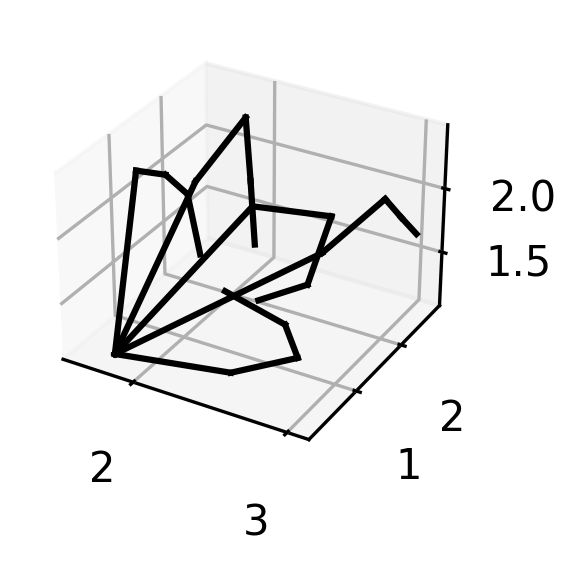

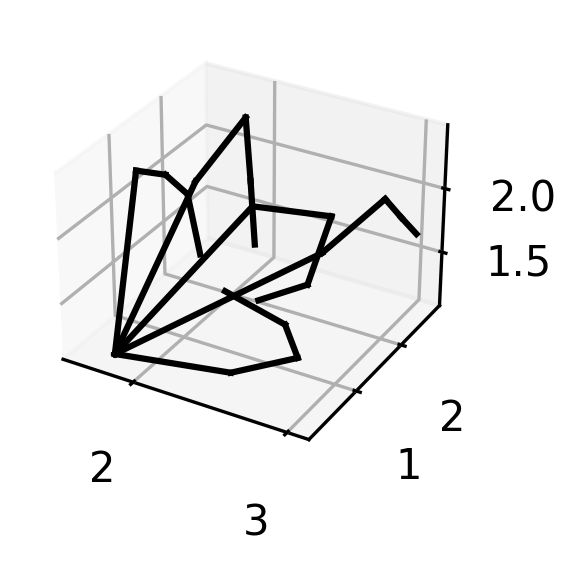

KeyboardInterrupt: 

In [31]:

import pickle5 as pickle
from PIL import Image
import json
import cv2
import torch
import numpy as np
import os
import matplotlib.pyplot as plt



for idx in range(0, 70):

    raw_res = 512
    bg_path = "../../datasets/without_bg_revision/background"
    bg_list = os.listdir(bg_path)
    img_path = os.path.join("../../datasets/without_bg_revision", f"images/train")
    name = '/'.join(meta[idx]['file_name'].split('/')[1:])
    image = cv2.imread(os.path.join(img_path, name))  # PIL image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)[:,:, (2, 1, 0)]
    
    joint_2d = np.array(meta[idx]['joint_2d'])
    joint_3d = meta[idx]['joint_3d']    
    scale = meta[idx]['scale']   
    rot = meta[idx]['rot']       

    cropped_img = crop(image, (raw_res/2, raw_res/2), scale, [raw_res, raw_res], rot=rot)
    bg_img = cv2.imread(os.path.join(bg_path, bg_list[idx%len(bg_list)]))
    bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB)
    bg_img = cv2.resize(bg_img, (512, 512))

    ori = cropped_img.copy()
    iaz = np.where((cropped_img[:, :, 0] == 0) & (cropped_img[:, :, 1] == 0) & (cropped_img[:, :, 2] == 0))
    cropped_img[iaz] = bg_img[iaz]
    cropped_img2 = visualize(cropped_img.copy(), joint_2d)
      
    new_image = np.zeros((512, 512, 3))
    index = np.where((ori[:, :, 0] != 0) | (ori[:, :, 1] != 0) | (ori[:, :, 2] != 0))
    index = np.array(index)
    bbox_image = [min(index[0]), max(index[0]), min(index[1]), max(index[1])]
    bbox = [min(joint_2d[:, 1]),  max(joint_2d[:, 1]), min(joint_2d[:, 0]), max(joint_2d[:, 0])]
    dia_of_bbox = np.sqrt((bbox[0] - bbox[1]) ** 2 + (bbox[2] -bbox[3]) ** 2) / 512
    dia_of_hand = np.sqrt((bbox_image[0] - bbox_image[1]) ** 2 + (bbox_image[2] - bbox_image[3]) ** 2) / 512
    ratio_of_dia = dia_of_bbox / dia_of_hand
    a = int(max(bbox[0] - (ratio_of_dia * 100), 0))
    b = int(min(bbox[1] + (ratio_of_dia * 100), 512))
    c = int(max(bbox[2] - (ratio_of_dia * 100), 0))
    d = int(min(bbox[3] + (ratio_of_dia * 100), 512))
    new_image[a : b, c : d] = ori[a : b, c: d]
    iaz = np.where((new_image[:, :, 0] == 0) & (new_image[:, :, 1] == 0) & (new_image[:, :, 2] == 0))
    new_image[iaz] = bg_img[iaz]
    cropped_img3 = visualize(new_image.copy(), joint_2d)
    
    fig = plt.figure(dpi= 300)
    ax1 = fig.add_subplot(131, projection ='3d')
    parents = [-1, 0, 1, 2, 3, 0, 5, 6, 7, 0, 9, 10, 11, 0, 13, 14, 15, 0, 17, 18, 19]

    for num in range(1,21):
        ax1.plot([joint_3d[num][0], joint_3d[parents[num]][0]], [joint_3d[num][1], joint_3d[parents[num]][1]], [joint_3d[num][2], joint_3d[parents[num]][2]], c = np.array((0, 0, 0))/255.)
        
    plt.show()

    cv2.imwrite(f"arm/cropped_{idx}.png", cropped_img2)
    cv2.imwrite(f"without_arm/cropped_hand_{idx}.png", cropped_img3) 

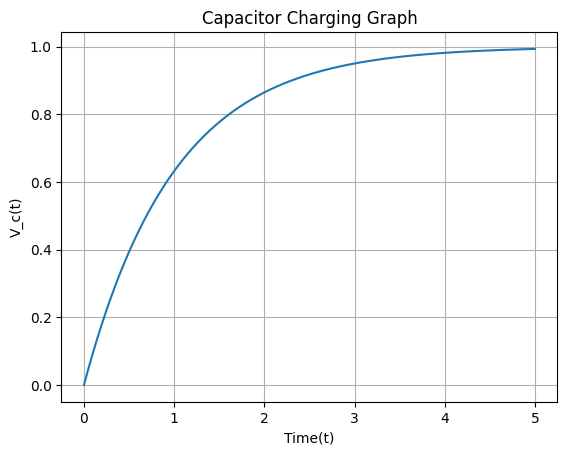

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def charging_graph(R, C, V0, t):
    # R: 저항(Resistance)
    # C: 커패시터 용량(Capacitance)
    # V0: 초기 전압(Voltage)
    # t: 시간

    # 충전 그래프를 계산하기 위해 시간을 배열로 생성
    time = np.linspace(0, t, num=1000)

    # 충전 그래프를 계산
    voltage = V0 * (1 - np.exp(-time / (R * C)))

    # 그래프 그리기
    plt.plot(time, voltage)
    plt.xlabel('Time(t)')
    plt.ylabel('V_c(t)')
    plt.title('Capacitor Charging Graph')
    plt.grid(True)
    plt.show()

# 예시로 R = 1000 옴, C = 0.001 파라미터를 사용하겠습니다.
R = 1000
C = 0.001
V0 = 1.0  # 초기 전압
t = 5.0    # 시간

charging_graph(R, C, V0, t)


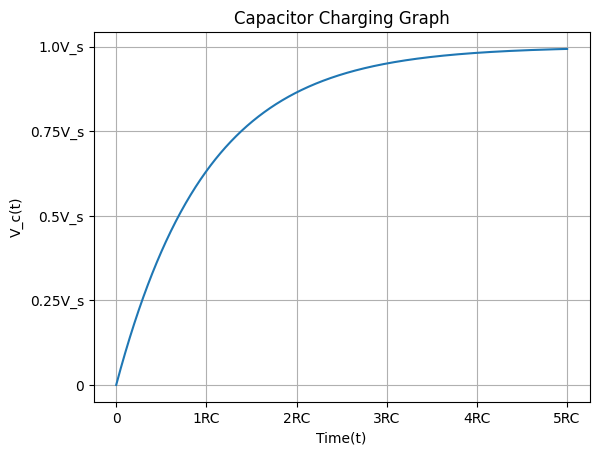

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def charging_graph(R, C, V0, t):
    time = np.linspace(0, t, num=1000)
    voltage = V0 * (1 - np.exp(-time / (R * C)))

    plt.plot(time, voltage)
    plt.xlabel('Time(t)')
    plt.ylabel('V_c(t)')
    plt.title('Capacitor Charging Graph')
    plt.grid(True)

    # x축의 값에 문자 추가
    x_ticks = [0, t/5, t*2/5, 3*t/5, 4*t/5,t]  # x축의 눈금 위치
    x_labels = ['0', '1RC', '2RC', '3RC', '4RC', '5RC']  # 눈금에 대응하는 문자열
    plt.xticks(x_ticks, x_labels)
    
        # y축의 값에 문자 추가
    y_ticks = [0, V0/4, V0/2, 3*V0/4, V0]  # y축의 눈금 위치
    y_labels = ['0', '0.25V_s', '0.5V_s', '0.75V_s', '1.0V_s']  # 눈금에 대응하는 문자열
    plt.yticks(y_ticks, y_labels)

    plt.show()

R = 1000
C = 0.001
V0 = 1.0
t = 5.0

charging_graph(R, C, V0, t)


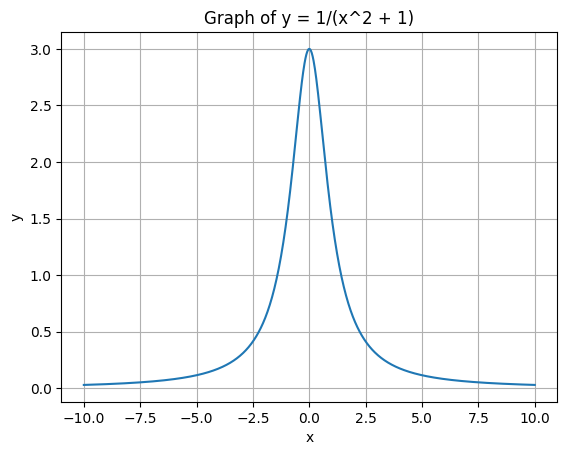

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# x 값 범위 설정
x = np.linspace(-10, 10, 1000)

# 함수 정의
y = 3 / (x**2 + 1)

# 그래프 그리기
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Graph of y = 1/(x^2 + 1)')
plt.grid(True)
plt.show()
